In [ ]:
import pybedtools
import pyranges

gencode = pyranges.read_gtf("../data/gencode.v40.basic.annotation.gtf")
gm12878_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF338RIC.bed").to_dataframe()
h1esc_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF323HNB.bed").to_dataframe()
hffc6_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF393FSC.bed").to_dataframe()

active_gene_states = ['TssA', 'TssAFlnk', 'TxFlnk', 'Tx', 'TxWk', 'EnhG', 'EnhG1', 'EnhG2', 'Enh', 'EnhA1', 'EnhA2']

In [ ]:
# cut .xx postfix from gene_id
# gencode['gene_id'] = gencode['gene_id'].str.split('.')[0]
genes_from_gencode = (
    gencode
    [(gencode['Feature'] == 'gene') & (gencode['gene_type'] == 'protein_coding')]
    [['Chromosome', 'Start', 'End', 'gene_id']]
)

genes_from_gencode['gene_id'] = genes_from_gencode['gene_id'].str.split('.').str[0]

genes_from_gencode

In [ ]:
import pandas as pd

distances_with_links = pd.read_parquet("./links/experiment_4/distances_with_links.parquet").rename({"dist_avg_dist": "avg_dist"}, axis=1)
gm12878_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'GM12878']
hffc6_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'HFFC6']
h1esc_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'H1ESC']

In [ ]:
distance_cutoff = {
    'H1ESC_Nean': 1.5819487888988626,
    'H1ESC_Deni': 1.5940225214185284,
    'HFFC6_Nean': 1.4982763183612486,
    'HFFC6_Deni': 1.7777412978743463,
    'WTC11_Nean': 0.49185075802354294,
    'WTC11_Deni': 0.49946283771094635,
    'GM12878_Nean': 1.3194976373807719,
    'GM12878_Deni': 1.2678860440889042
}

gm12878_neanderthal_df_ref = gm12878_neanderthal_df_ref[gm12878_neanderthal_df_ref["avg_dist"] > distance_cutoff["GM12878_Nean"]]
hffc6_neanderthal_df_ref = hffc6_neanderthal_df_ref[hffc6_neanderthal_df_ref["avg_dist"] > distance_cutoff["HFFC6_Nean"]]
h1esc_neanderthal_df_ref = h1esc_neanderthal_df_ref[h1esc_neanderthal_df_ref["avg_dist"] > distance_cutoff["H1ESC_Nean"]]

In [ ]:
# Attach gene coordinates to the distances, split enh_id (chrX:12345-67890) into chromosome, start, end
gm12878_neanderthal_df_ref = (
    gm12878_neanderthal_df_ref
    .merge(genes_from_gencode, left_on='gene_id', right_on='gene_id', how='left', suffixes=('', '_gene'))
    .rename({'Chromosome': 'gene_chromosome', 'Start': 'gene_start', 'End': 'gene_end'}, axis=1)
)
gm12878_neanderthal_df_ref[['enh_chromosome', 'enh_start', 'enh_end']] = gm12878_neanderthal_df_ref['enh_id'].str.split(':|-', expand=True)
gm12878_neanderthal_df_ref['enh_start'] = gm12878_neanderthal_df_ref['enh_start'].astype(int)
gm12878_neanderthal_df_ref['enh_end'] = gm12878_neanderthal_df_ref['enh_end'].astype(int)

hffc6_neanderthal_df_ref = (
    hffc6_neanderthal_df_ref
    .merge(genes_from_gencode, left_on='gene_id', right_on='gene_id', how='left', suffixes=('', '_gene'))
    .rename({'Chromosome': 'gene_chromosome', 'Start': 'gene_start', 'End': 'gene_end'}, axis=1)
)
hffc6_neanderthal_df_ref[['enh_chromosome', 'enh_start', 'enh_end']] = hffc6_neanderthal_df_ref['enh_id'].str.split(':|-', expand=True)
hffc6_neanderthal_df_ref['enh_start'] = hffc6_neanderthal_df_ref['enh_start'].astype(int)
hffc6_neanderthal_df_ref['enh_end'] = hffc6_neanderthal_df_ref['enh_end'].astype(int)

h1esc_neanderthal_df_ref = (
    h1esc_neanderthal_df_ref
    .merge(genes_from_gencode, left_on='gene_id', right_on='gene_id', how='left', suffixes=('', '_gene'))
    .rename({'Chromosome': 'gene_chromosome', 'Start': 'gene_start', 'End': 'gene_end'}, axis=1)
)
h1esc_neanderthal_df_ref[['enh_chromosome', 'enh_start', 'enh_end']] = h1esc_neanderthal_df_ref['enh_id'].str.split(':|-', expand=True)
h1esc_neanderthal_df_ref['enh_start'] = h1esc_neanderthal_df_ref['enh_start'].astype(int)
h1esc_neanderthal_df_ref['enh_end'] = h1esc_neanderthal_df_ref['enh_end'].astype(int)

In [ ]:
def mark_active_regions(df, chromatin_states_df, active_gene_states):
    # Create PyRanges for active regions
    active_regions_pr = pyranges.PyRanges(
        {
            "Chromosome": chromatin_states_df['chrom'][chromatin_states_df['name'].isin(active_gene_states)],
            "Start": chromatin_states_df['start'][chromatin_states_df['name'].isin(active_gene_states)],
            "End": chromatin_states_df['end'][chromatin_states_df['name'].isin(active_gene_states)]
        }
    )

    # Create PyRanges objects for genes and enhancers with index as identifier
    genes_pr = pyranges.PyRanges(
        {
            "Chromosome": df['gene_chromosome'],
            "Start": df['gene_start'],
            "End": df['gene_end'],
            "row_id": df.index
        }
    )

    enhancers_pr = pyranges.PyRanges(
        {
            "Chromosome": df['enh_chromosome'],
            "Start": df['enh_start'],
            "End": df['enh_end'],
            "row_id": df.index
        }
    )

    # Find genes and enhancers that overlap with active regions
    active_genes = genes_pr.intersect(active_regions_pr)
    active_enhancers = enhancers_pr.intersect(active_regions_pr)

    # Get sets of row IDs where genes and enhancers are active
    active_gene_rows = set(active_genes['row_id']) if not active_genes.empty else set()
    active_enhancer_rows = set(active_enhancers['row_id']) if not active_enhancers.empty else set()

    # Find rows where both gene and enhancer are active (intersection of sets)
    active_rows = active_gene_rows.intersection(active_enhancer_rows)

    # Create a copy of the input dataframe with the is_active column added
    result_df = df.copy()
    result_df['is_active'] = result_df.index.isin(active_rows)

    return result_df

gm12878_neanderthal_df_ref = mark_active_regions(gm12878_neanderthal_df_ref, gm12878_chromatin_states, active_gene_states)
gm12878_neanderthal_df_ref = gm12878_neanderthal_df_ref[gm12878_neanderthal_df_ref['is_active']].drop(columns=['is_active'])

hffc6_neanderthal_df_ref = mark_active_regions(hffc6_neanderthal_df_ref, hffc6_chromatin_states, active_gene_states)
hffc6_neanderthal_df_ref = hffc6_neanderthal_df_ref[hffc6_neanderthal_df_ref['is_active']].drop(columns=['is_active'])

h1esc_neanderthal_df_ref = mark_active_regions(h1esc_neanderthal_df_ref, h1esc_chromatin_states, active_gene_states)
h1esc_neanderthal_df_ref = h1esc_neanderthal_df_ref[h1esc_neanderthal_df_ref['is_active']].drop(columns=['is_active'])

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

with open("../data/rnaseq/gm12878_read_count.txt", "r") as f:
    # Skip the first line
    f.readline()
    gm12878_counts_df = pd.read_csv(f, index_col=0, sep="\t")


with open("../data/rnaseq/h1esc_read_count.txt", "r") as f:
    # Skip the first line
    f.readline()
    h1esc_counts_df = pd.read_csv(f, index_col=0, sep="\t")

with open("../data/rnaseq/hffc6_read_count.txt", "r") as f:
    # Skip the first line
    f.readline()
    hffc6_counts_df = pd.read_csv(f, index_col=0, sep="\t")

gm12878_counts_df = gm12878_counts_df[['ENCFF800HIP.filtered.bam', 'ENCFF991KKX.filtered.bam']].T
h1esc_counts_df = h1esc_counts_df[['ENCFF675NTU.filtered.bam', 'ENCFF379NOY.filtered.bam']].T
hffc6_counts_df = hffc6_counts_df[['ENCFF307KUI.filtered.bam', 'ENCFF294BSI.filtered.bam', 'ENCFF937TEI.filtered.bam']].T

def compute_deseq_stats_for_2_celllines(cellline1_counts_df, cellline2_counts_df, cellline1_name="CellLine1", cellline2_name="CellLine2"):
    cl1_vs_cl2_counts_df = pd.concat(
        [cellline1_counts_df, cellline2_counts_df]
    )

    cl1_vs_cl2_metadata_df = pd.DataFrame(
        {
            "condition": [cellline1_name] * cellline1_counts_df.shape[0] + [cellline2_name] * cellline2_counts_df.shape[0]
        },
        index=cl1_vs_cl2_counts_df.index,
    )

    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
        counts=cl1_vs_cl2_counts_df,
        metadata=cl1_vs_cl2_metadata_df,
        design="~condition",
        refit_cooks=True,
        inference=inference,
    )

    dds.deseq2()
    stats = DeseqStats(dds, contrast=["condition", cellline1_name, cellline2_name])
    stats.summary()

    results_df = stats.results_df.dropna()
    results_df['symbol'] = results_df.index
    return results_df

gm12878_vs_h1esc_results_df = compute_deseq_stats_for_2_celllines(
    gm12878_counts_df,
    h1esc_counts_df,
    cellline1_name="GM12878",
    cellline2_name="H1ESC"
)

h1esc_vs_hffc6_results_df = compute_deseq_stats_for_2_celllines(
    h1esc_counts_df,
    hffc6_counts_df,
    cellline1_name="H1ESC",
    cellline2_name="HFFC6"
)

hffc6_vs_gm12878_results_df = compute_deseq_stats_for_2_celllines(
    hffc6_counts_df,
    gm12878_counts_df,
    cellline1_name="HFFC6",
    cellline2_name="GM12878"
)

In [ ]:

gm12878_gene_to_closest_avg_enhancer_all = (
    gm12878_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)
gm12878_gene_to_closest_avg_enhancer_all['has_link'] = (
    gm12878_gene_to_closest_avg_enhancer_all.index
    .isin(gm12878_neanderthal_df_ref[gm12878_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

hffc6_gene_to_closest_avg_enhancer_all = (
    hffc6_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)

hffc6_gene_to_closest_avg_enhancer_all['has_link'] = (
    hffc6_gene_to_closest_avg_enhancer_all.index
    .isin(hffc6_neanderthal_df_ref[hffc6_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

h1esc_gene_to_closest_avg_enhancer_all = (
    h1esc_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)

h1esc_gene_to_closest_avg_enhancer_all['has_link'] = (
    h1esc_gene_to_closest_avg_enhancer_all.index
    .isin(h1esc_neanderthal_df_ref[h1esc_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

for df, name in [
    (gm12878_gene_to_closest_avg_enhancer_all, 'gm12878'),
    (hffc6_gene_to_closest_avg_enhancer_all, 'hffc6'),
    (h1esc_gene_to_closest_avg_enhancer_all, 'h1esc'),
]:
    q1 = df['min_dist'].quantile(0.33)
    q3 = df['min_dist'].quantile(0.66)
    def label_quartile(x):
        if x <= q1:
            return 'small'
        elif x <= q3:
            return 'mid'
        else:
            return 'large'
    df['quartile_cat'] = df['min_dist'].apply(label_quartile)

In [124]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np
import joypy
from matplotlib import cm

def plot_distance_vs_expression_correlation(
    cell1_distances_df,
    cell2_distances_df,
    deseq_results_df,
    cell1_name,
    cell2_name,
    figsize=(20, 20),
    plot_path=None,
    color_map=cm.viridis,
    font_size=18,
    log2fc_threshold=2,
    padj_threshold=0.05
):
    deseq_results_df = deseq_results_df.copy()

    # Cut .xx from gene index of
    deseq_results_df.index = deseq_results_df.index.str.split('.').str[0]

    deseq_results_df = deseq_results_df[
        (deseq_results_df["padj"] < padj_threshold)
        & (deseq_results_df["log2FoldChange"].abs() > log2fc_threshold)
    ]

    # Normalize all distances against average distance
    cell1_distances_df = cell1_distances_df.copy()
    cell1_distances_df['norm_min_dist'] = (
        (cell1_distances_df['min_dist'] - cell1_distances_df['min_dist'].min()) / (cell1_distances_df['min_dist'].max() - cell1_distances_df['min_dist'].min())
    )

    cell2_distances_df = cell2_distances_df.copy()
    cell2_distances_df['norm_min_dist'] = (
        (cell2_distances_df['min_dist'] - cell2_distances_df['min_dist'].min()) / (cell2_distances_df['min_dist'].max() - cell2_distances_df['min_dist'].min())
    )

    # Join the two distance dataframes
    combined_df = cell1_distances_df.merge(
        cell2_distances_df,
        left_index=True,
        right_index=True,
        how="inner",
        suffixes=(f"_{cell1_name}", f"_{cell2_name}")
    )

    # Calculate min_dist change (log ratio for better scaling)
    combined_df["log_dist_ratio"] = np.log2(combined_df[f"min_dist_{cell1_name}"] / combined_df[f"min_dist_{cell2_name}"])
    combined_df["dist_diff"] = combined_df[f"min_dist_{cell1_name}"] - combined_df[f"min_dist_{cell2_name}"]

    combined_df["norm_dist_diff"] = combined_df[f"norm_min_dist_{cell1_name}"] - combined_df[f"norm_min_dist_{cell2_name}"]
    combined_df["log_norm_dist_ratio"] = np.log2(combined_df[f"norm_min_dist_{cell1_name}"] / combined_df[f"norm_min_dist_{cell2_name}"])

    # Define link change categories
    def get_link_change(row):
        if row[f"has_link_{cell1_name}"] and not row[f"has_link_{cell2_name}"]:
            return f"Only {cell1_name}"
        elif not row[f"has_link_{cell1_name}"] and row[f"has_link_{cell2_name}"]:
            return f"Only {cell2_name}"
        elif row[f"has_link_{cell1_name}"] and row[f"has_link_{cell2_name}"]:
            return "Both"
        else:
            return "Neither"

    combined_df["link_status"] = combined_df.apply(get_link_change, axis=1)

    # Define quartile change categories
    def get_quartile_change(row):
        q1 = row[f"quartile_cat_{cell1_name}"]
        q2 = row[f"quartile_cat_{cell2_name}"]

        if q1 == q2:
            return "No change"

        categories = ["small", "mid", "large"]
        idx1 = categories.index(q1)
        idx2 = categories.index(q2)

        if idx1 > idx2:
            return f"Decreased ({q1} to {q2})"
        else:
            return f"Increased ({q1} to {q2})"

    combined_df["quartile_change"] = combined_df.apply(get_quartile_change, axis=1)

    # Merge with DESeq2 results
    merged_df = combined_df.merge(
        deseq_results_df[["log2FoldChange", "padj"]],
        left_index=True,
        right_index=True,
        how="inner"
    )

    merged_df_for_correlation = merged_df.copy()
    # Filter out insignificant changes in quartile change
    merged_df_for_correlation = merged_df_for_correlation[
        ~merged_df_for_correlation["quartile_change"].isin([
            "No change",
            "Increased (small to mid)",
            "Increased (mid to large)",
            "Decreased (large to mid)",
            "Decreased (mid to small)",
        ])
    ]

    merged_df_for_plotting = merged_df.copy()
    merged_df_for_plotting = merged_df_for_plotting[
        ~merged_df_for_plotting["quartile_change"].isin([
            "Increased (small to mid)",
            "Increased (mid to large)",
            "Decreased (large to mid)",
            "Decreased (mid to small)",
        ])
    ]

    # Calculate and display correlation
    # pearson_r, pearson_p = pearsonr(merged_df_for_correlation["log_dist_ratio"], merged_df_for_correlation["log2FoldChange"], alternative='two-sided') - data is not normally distributed
    spearman_r, spearman_p = spearmanr(merged_df_for_correlation["log_dist_ratio"], merged_df_for_correlation["log2FoldChange"], alternative='two-sided')

    # Plot: Log2 fold change by quartile change
    # Define order for visualization
    quartile_order = [
        "Increased (small to large)",
        # "Increased (mid to large)",
        # "Increased (small to mid)",
        "No change",
        "Decreased (large to small)",
        # "Decreased (mid to small)",
        # "Decreased (large to mid)"
    ]

    # Filter out empty categories
    available_categories = merged_df_for_plotting["quartile_change"].unique()
    plot_order = [cat for cat in quartile_order if cat in available_categories]

    # Create plot data dictionary
    plot_data = {}
    for category in plot_order:
        subset = merged_df_for_plotting[merged_df_for_plotting["quartile_change"] == category]
        if len(subset) >= 3:  # Minimum data points for KDE
            plot_data[category] = subset["log2FoldChange"]

    # Create figure
    fig, axes = joypy.joyplot(
        plot_data,
        figsize=figsize,
        colormap=color_map,
        overlap=0.7,
        linewidth=1,
        alpha=0.8,
        grid="y",
        legend=False,
        title=f"Expression Change by Distance Change for {cell1_name} vs {cell2_name}\n" +
              # f"Pearson r: {pearson_r:.3f} (p: {pearson_p:.2e}) | " +
              f"Spearman r: {spearman_r:.3f} (p: {spearman_p:.2e})",
        range_style='own',

    )

    # print(f'Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.2e}')
    print(f'Spearman r: {spearman_r:.3f}, p-value: {spearman_p:.2e}')

    # Customize plot
    plt.xlabel("Log2 Fold Change", fontsize=font_size)

    # Add gray vertical lines at log2FC = 0
    for ax in axes[:-1]:  # Skip the last ax which is just for the x-axis
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    # Add vertical lines at log2FC = -1 and log2FC = 1 to each subplot
    for ax in axes[:-1]:  # Skip the last ax which is just for the x-axis
        ax.axvline(x=-log2fc_threshold, color='gray', linestyle='--', alpha=0.7, linewidth=1)
        ax.axvline(x=log2fc_threshold, color='gray', linestyle='--', alpha=0.7, linewidth=1)

    title = axes[-1].get_title()
    axes[-1].set_title(title, fontsize=font_size)
    for ax in axes:
        label = ax.get_yticklabels()
        ax.set_yticklabels(label, fontsize=font_size)
    # # Add red vertical link at mean of log2FoldChange for each quartile change
    # for ax, category in zip(axes[:-1], plot_order):
    #     if category in plot_data:
    #         mean_value = plot_data[category].mean()
    #         ax.axvline(x=mean_value, color='red', linestyle='-', alpha=0.7, linewidth=1)

    # Add legend with better position
    handles = []
    for i, label in enumerate(plot_data.keys()):
        color = color_map(i / len(plot_data))
        handles.append(plt.Rectangle((0,0), 1, 1, color=color, alpha=0.7))

    # Add threshold lines to legend
    handles.append(plt.Line2D([0], [0], color='gray', linestyle='--', alpha=0.7))
    legend_labels = list(plot_data.keys()) + [f'Significance threshold (|log2FC| > {log2fc_threshold})']

    # handles.append(plt.Line2D([0], [0], color='red', linestyle='-', alpha=0.7))
    # legend_labels.append('Mean log2FC for each quartile change')

    plt.figlegend(
        handles, legend_labels,
        loc="upper left",
        bbox_to_anchor=(0.99, 0.98),
        title="Quartile Change",
        fontsize=font_size,
    )

    if plot_path:
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    else:
        plt.tight_layout()

    return fig, merged_df

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log2

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_14059/1618299180.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Spearman r: -0.569, p-value: 2.51e-10


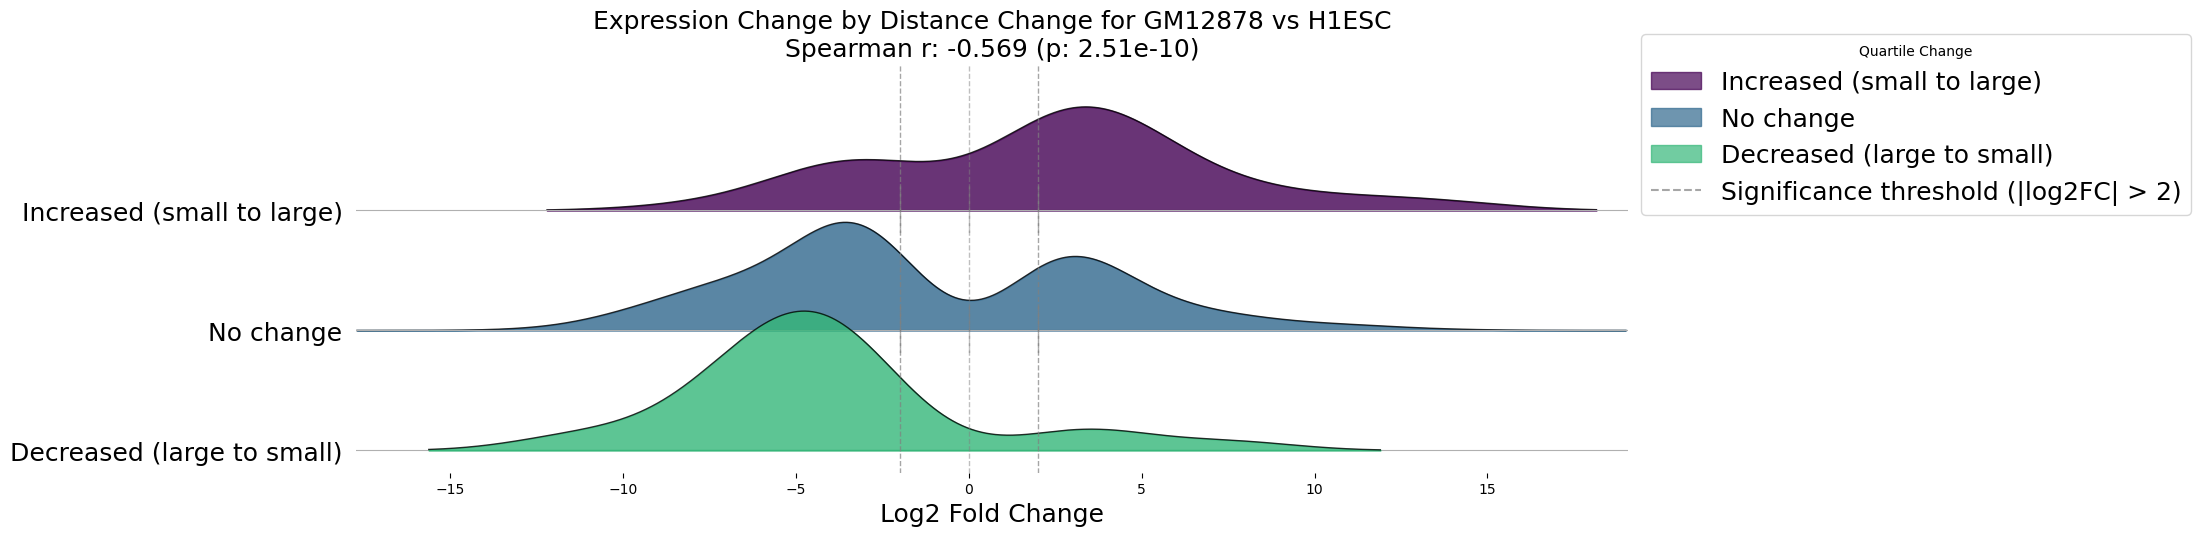

In [125]:
# Example usage
fig, corr_data = plot_distance_vs_expression_correlation(
    gm12878_gene_to_closest_avg_enhancer_all,
    h1esc_gene_to_closest_avg_enhancer_all,
    gm12878_vs_h1esc_results_df,
    "GM12878",
    "H1ESC",
    figsize=(15, 5),
    plot_path="figs/exp4_gm_h1_joy.png"
)
plt.show()

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log2

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_14059/1618299180.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Spearman r: -0.577, p-value: 2.30e-11


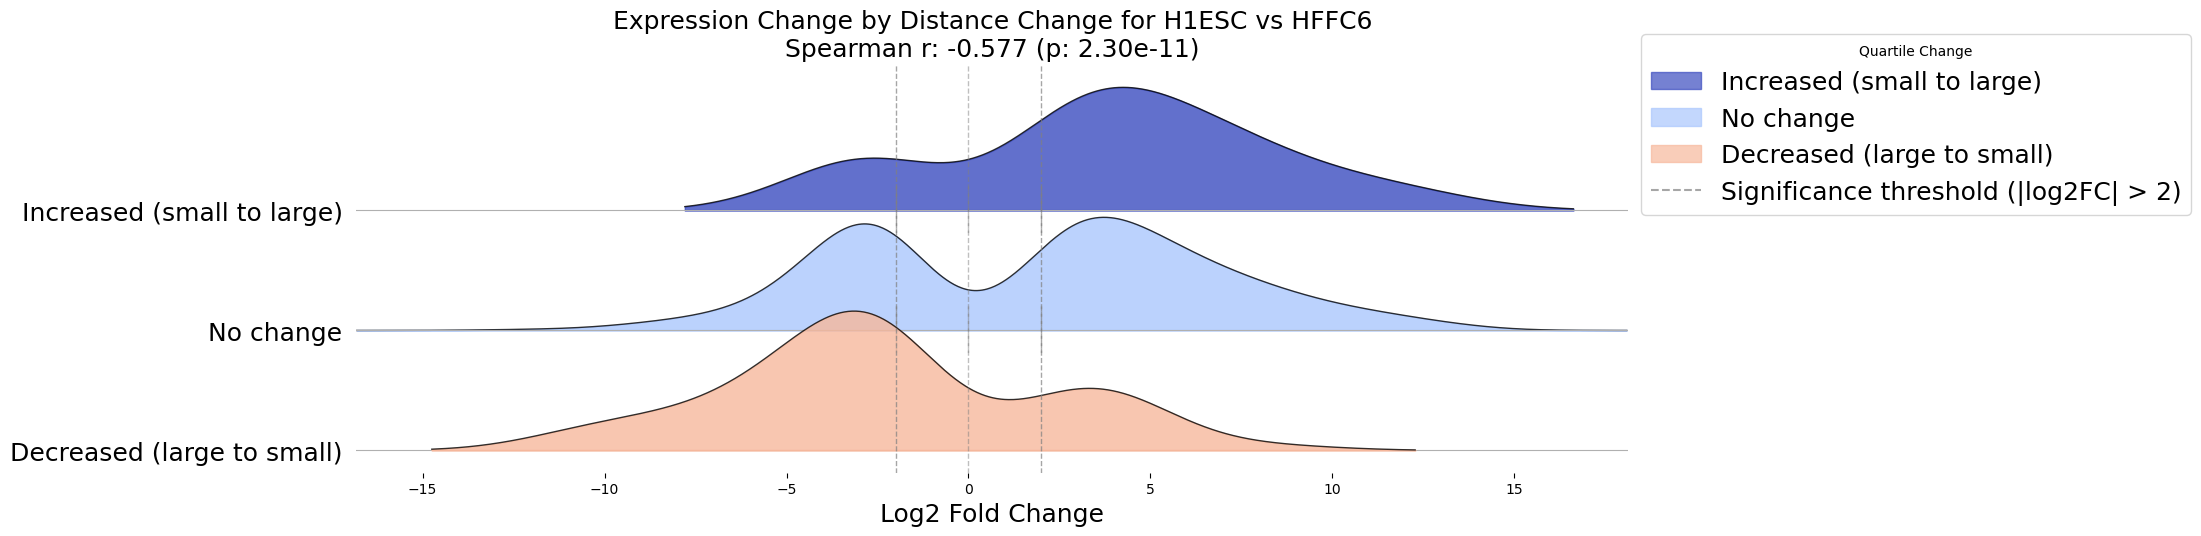

In [126]:
fig, corr_data = plot_distance_vs_expression_correlation(
    h1esc_gene_to_closest_avg_enhancer_all,
    hffc6_gene_to_closest_avg_enhancer_all,
    h1esc_vs_hffc6_results_df,
    "H1ESC",
    "HFFC6",
    figsize=(15, 5),
    plot_path="figs/exp4_h1_hffc_joy.png",
    color_map=cm.coolwarm
)

plt.show()

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log2

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_14059/1618299180.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Spearman r: -0.646, p-value: 6.66e-13


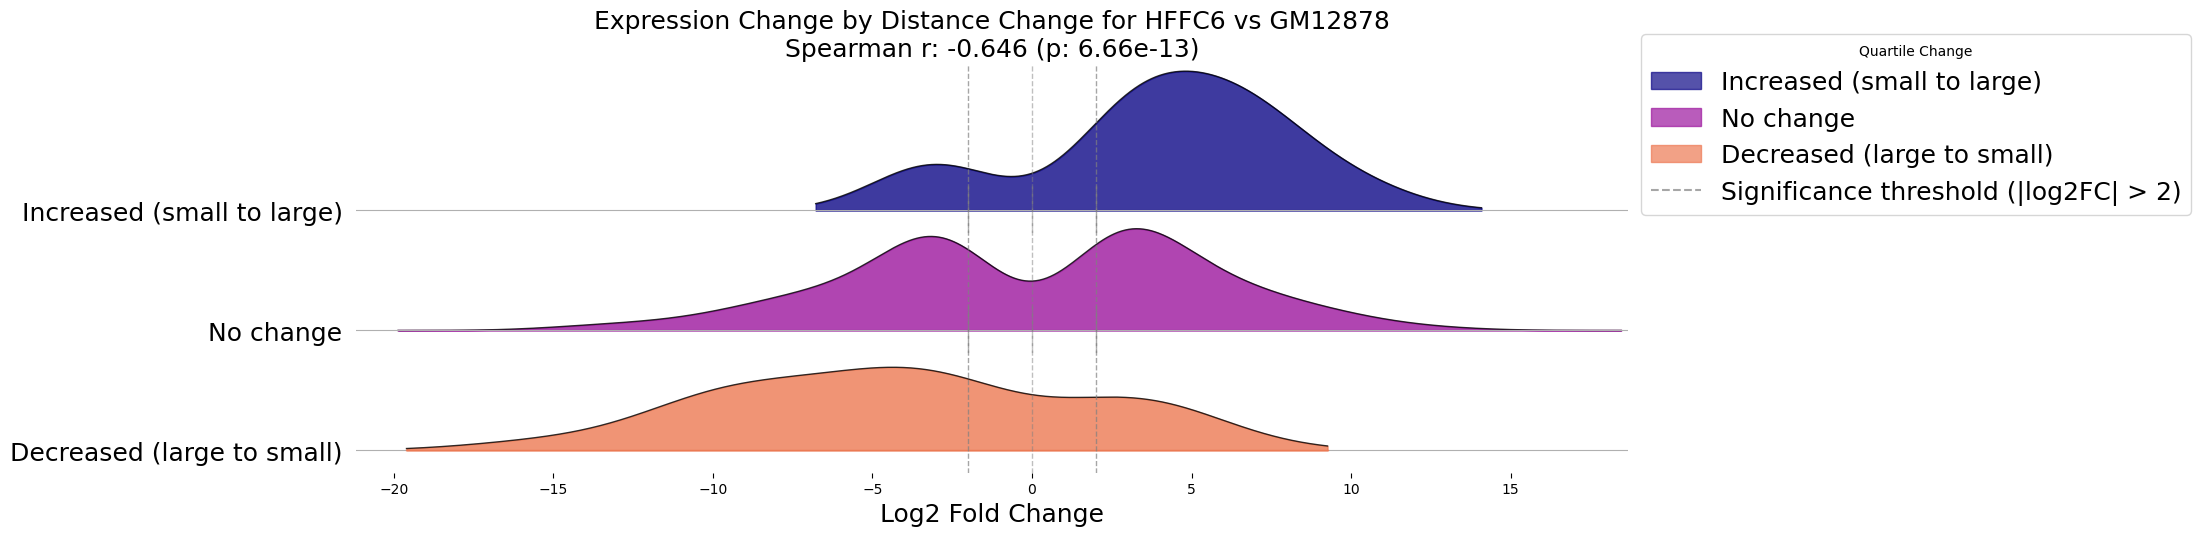

In [127]:
fig, corr_data = plot_distance_vs_expression_correlation(
    hffc6_gene_to_closest_avg_enhancer_all,
    gm12878_gene_to_closest_avg_enhancer_all,
    hffc6_vs_gm12878_results_df,
    "HFFC6",
    "GM12878",
    figsize=(15, 5),
    plot_path="figs/exp4_hffc_gm_joy.png",
    color_map=cm.plasma
)

plt.show()